# Topic 16: Logistic Regression

We have been looking at linear regression.  This type of regression is used when we are looking for a numeric output: What is the expected selling price for a house with these characteristics?  It is assumed that the output is a numeric value that is in a wide range of possibilities.

A second type of regression, _logistic regression_, is used when we want to _classify_: Does this sample belong to _set 1_ or _set 2_.  There are actually a couple of additional forms of logistic regression questions, but this _binary classification_ form is quite typical.  For example, with these various characteristics, is this tumor malignant or benign?  Will this team win the football game?  Is this credit card transaction fradulent?

As with linear regression, logistic regression is trained on a labeled set of samples.  The algorithm learns from these examples, then uses this information to classify new examples.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

## Basic Equations

* The model for a linear regression is a polynomial of degree _n_.

* The model for a logistic regression starts with a polynomial, but then the result is passed through a _logistic equation_.  

This is the basic form of the linear regression model:

$$ y = \Omega_0 + \Omega_1 x^1 + \Omega_2 x^2 + ... + \Omega_n x^n $$

There are a couple of logistic equations.  The _sigmoid_ function is common:

$$ p = \frac{e^\lambda}{e^\lambda + 1} $$

Writing this in another way:

$$ p = \frac{1}{1 + e^{-\lambda}} $$

Applying the sigmoid function to the linear equation we get:

$$ p = \frac{1}{1 + e^{-(\Omega_0 + \Omega_1 x^1 + \Omega_2 x^2 + ... + \Omega_n x^n)}} $$

This looks horrible.  However, the computer has to solve these equations, we don't, so perhaps this is not so bad.

What is the purpose in using the sigmoid function (or one of the other logistic functions)?  This is best seen by looking at some plots.

For this first plot, we see some points, fitted with a linear regression of degree 1, in blue, and these same points, transformed by the sigmoid function, in red:

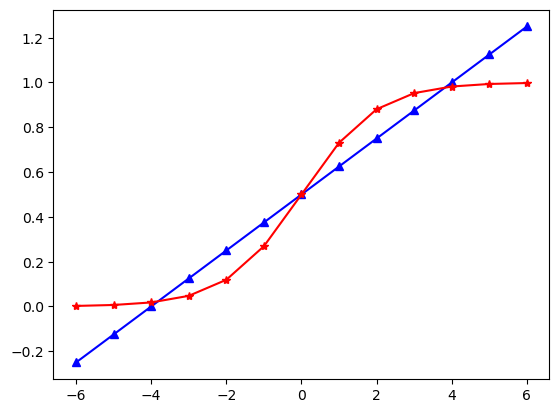

In [2]:
x_values = range(-6, 7)
lin_values = [x / 8 + 0.5 for x in x_values]
log_values = [exp(x) / (1 + exp(x)) for x in x_values]
plt.plot(x_values, lin_values, 'b-^')
plt.plot(x_values, log_values, 'r-*')
plt.show()

One may ask, "so what?"

Let's see another plot, with some data values, comparing the results:

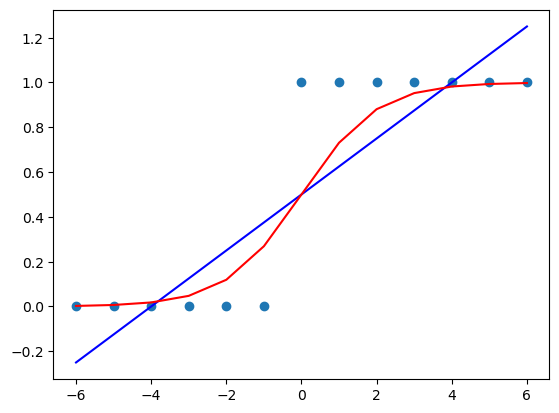

In [3]:
y_values = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
plt.scatter(x_values, y_values)
plt.plot(x_values, lin_values, 'b-')
plt.plot(x_values, log_values, 'r-')
plt.show()

There are two main points to consider:

* The linear equation's output ranges from $ -\infty $ to $ +\infty $, where the sigmoid's output ranges from 0 to 1.  If we want a bounded output, the sigmoid would be the better equation.

* For a classification problem, we want to determine whether a sample is in _set 1_ or _set 2_.  With a linear regression, the output is not classified, we get a numeric output.  We could say that if the output is above a given threshold, then the sample is in _set 2_.  For a sigmoid regression, the output is naturally classified, being either a 0 or a 1.  Yes, for _x_ values right near zero, the output is neither 1 nor 0, but we will talk about this.

To recap, if we are looking for a continuous output, we will be using linear regression, but if we are looking for a discrete output, we will be using logistic regression.

## Types of Logistic Regression

As mentioned above, there are three forms of Logistic Regression:

* Binary Logistic Regression

* Multinomial Logistic Regression

* Ordinal Logistic Regression

All of these are forms of classification, they are different types of classification.

### Binary Logistic Regression

This is the most common form of logistic regression, and is used when the target has two distinct values: 0 or 1, yes or no, pass or fail, admitted or barred, and so on.

### Multinomial Logistic Regression

This form of logistic regression is used when the output has three or more distinct possible values.  For example, the target might be Red, Yellow, or Blue.  Another example would be School 1, School 2, or School 3.  There are multiple output values, but no inherent ranking or ordering of them.

### Ordinal Logistic Regression

Ordinal logistic regression is used when the target variable is _ordinal_: the multiple output categories are ordered in a meaningful manner.  For example, the grades obtained for an exam have an order, an A is greater than a B, which is greater than a C.

Most of our discussion will be about binary logistic regression, but we will touch on the others.

## Example 1: Credit Card Fraud

I found this example in a tutorial on 'Logistic Regression in Python' by the Asper Brothers.

Our first example will consider credit card fraud, using a dataset from Kaggle.  This dataset has over 280,000 transactions, with 31 columns for each transaction.  Some of the columns are _time_, _amount_, and _class_ (which is the target).  The rest of the columns have just been given labels _V1_ through _V28_, and all of the values have been converted to numeric values, to protect the identity of the people who performed the transactions.

The data is in a CSV file (151 MBytes in size!). The following reads the data into a Pandas DataFrame.

In [5]:
df = pd.read_csv('creditcard.csv')

We will now do a little exploring of this set:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Looking at this report, we can see that there are no missing values in the data (every column has non-null entries in every row of the DataFrame).

Now let's look at a couple of the lines:

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Cleaning the dataset

As we've mentioned before, it is important to clean the dataset, to remove or repair data that would otherwise corrupt the results.  Again, we don't want to _steer_ the results, we are just removing bad data.

One thing that would be a problem would be to have duplicated rows.  For some of the regression algorithms, a duplicated row would carry twice the weight of other rows, and so adversly affect the results.

A DataFrame has a method which returns duplicated rows:

In [8]:
sum(df.duplicated())

1081

So, of the 284,807 rows, 1,081 are duplicates.  These are as easy to remove as they were to count!  In the following, the _inplace_ flag indicates that the code should change the source DataFrame, rather than create a new DataFrame that doesn't have the duplicates.

In [9]:
df.drop_duplicates(inplace = True)

As we saw with our linear regression examples, sometimes there are input columns that don't meaningfully affect the output.  If these remain in the dataset, this can confuse the regressor.  In this example, we do not consider the _Time_ to be a significant factor, so we will remove this column from the DataFrame.  One of the parameters passed to this routine is 'axis = 1'.  With this we are telling the DataFrame from which dimension to search for this label.  Axis 1 is the first dimension, so we are selecting a Column.  If we said 'axis = 2', this would be instructing the DataFrame to remove something from the second dimension, which in this case would be a row.

In [10]:
df.drop('Time', axis = 1, inplace=True)

We will split the DataFrame into input data and output data, features and targets.  The target will be the 'Class' column, and the features will be all other columns.  Note that the features will be in a DataFrame (i.e. 2-dimensional) while the target will be a Series (i.e. 1-dimensional).

Also, it seems like a convention is that the features are names 'X' (with a capital), while the target is named 'y' (with a lowercase letter).

In [11]:
y = df.Class;
X = df.iloc[:, df.columns != 'Class']

That expression for the value for X needs a little explanation:

* We are using the _iloc_ method to make a copy of the table.

* The [:] says to include all of the columns.  We could have put a value before the colon, which would have said which column would be the first column.  Since we didn't place anything here, it defaults to the first column.  We could have put a value after the colon, which would have said which column should stop the list (we would stop copying at that point).  Since we didn't place anything here, it defaults to the keep all the rest of the columns.  Hence we are asking for all of the columns.

* As a second parameter to _iloc_, we pass a filter which indicates which column(s) to keep.  We want to keep all of the columns except for the 'Class' column.

We have a little bit more clean up to do, but first we want to split the data into a training set and a testing set.  We can use train_test_split, but we have to be careful.

Remember in an earlier example, we built a pie chart to see how balanced the target was?  Let's see if this set is roughly balanced, that approximately half of the samples belong to each class.  Let's look at the _y_ data for a bit.

In [12]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [13]:
y.tail()

284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, dtype: int64

Hmmm... looking at those 10 samples, it doesn't look too balanced.  Let's count up how many rows are in the 'other class':

In [14]:
sum(y)

473

So there are 473 cases where there was fraud, out of 283,726 test cases (remember we removed duplicate rows).

If we did a test_train_split in this case, we would have a very good chance of not having many fraud cases in the test set, or at least we might not have a balanced set.

*train_test_split* has a parameter called _stratify_, by which we can pass a particular column.  This column is used to make sure that the test and training sets have proportional representations of rows for each value in this column.  We will use that feature to make sure our sets are balanced:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12, stratify=y)

One last thing to consider: We really don't know too much about this data, but the values in some columns may cover a much wider range than the data in other columns.  For example, the values in one column might range from 0 to 10, while in another column they might range from 0 to 1,000,000.  This large disparity of values can really hurt the distance calculations.  Consequently, we can scale or normalize the data.

It took a little experimenting to get this correct, but here are the steps I went through:

* The arrays we have built are DataFrames, and so they have names for all of the columns.  After we go through a scaling process, these names are stripped off.  In some of my later examples, the programs were complaining because either the training data had column names and the test data did not, or vice versa.

* I also found you cannot really remove the column names from a DataFrame.  So we can revert to using standard Python arrays, but these would be inefficient (and problematic for larger datasets).  Alternatively, we can stick with DataFrames, but then need to regenerate the column names.

* Sklearn.preprocessing.scale is a really easy method to use.  Pass it an array or a DataFrame, and it will automatically scale all of the columns that it can.  This is a one-step process.

```
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)
```

* Sklearn.preprocessing.StandardScaler is an alternate method.  For the StandardScaler, it must first be _fit_ to the data, then the data can be _transformed_.  This is a two-step process.

```
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
```

Why would we want the two-step process?

Consider the previous cell.  We took the dataset, then split it into a training set and a test set.  If we then independently scale them using _scale_, then each set might use a slightly different scaling factor.  This can introduce errors in our calculations!

If we used the StandardScaler, it is then fit on one set of data.  But then both sets of data are scaled by the same factor.  Consequently, this approach does not introduce errors.

An alternative, of course, it so scale the data before splitting into the test and training sets!

So let's continue, we have already split the data, so now we need to scale the data using the StandardScaler.  Then, after we are done, we convert the data back into a DataFrame, but we copy the columns from the original data!

A few extra steps here, but this cuts down on a lot of warning messages later!

In [16]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

Actually, in the tutorial I was following, they didn't scale the X_test data.  I do not know why not, they trained using scaled data, so I would think the test should also.  We will check later, trying to evaluate both the scaled and non-scaled test data.

As you can see in these examples, we did a lot of cleanup of the data set.  None of the fixes should have adversely affected the results, we just took out values that would confuse the trainer.  However, for this data we did not search for outliers.

## Visualization

We haven't seen any plots yet of our dataset.  It might be a good idea to see some plots, so we get a feel for the data.  One thing we can do is generate bar charts of each feature:

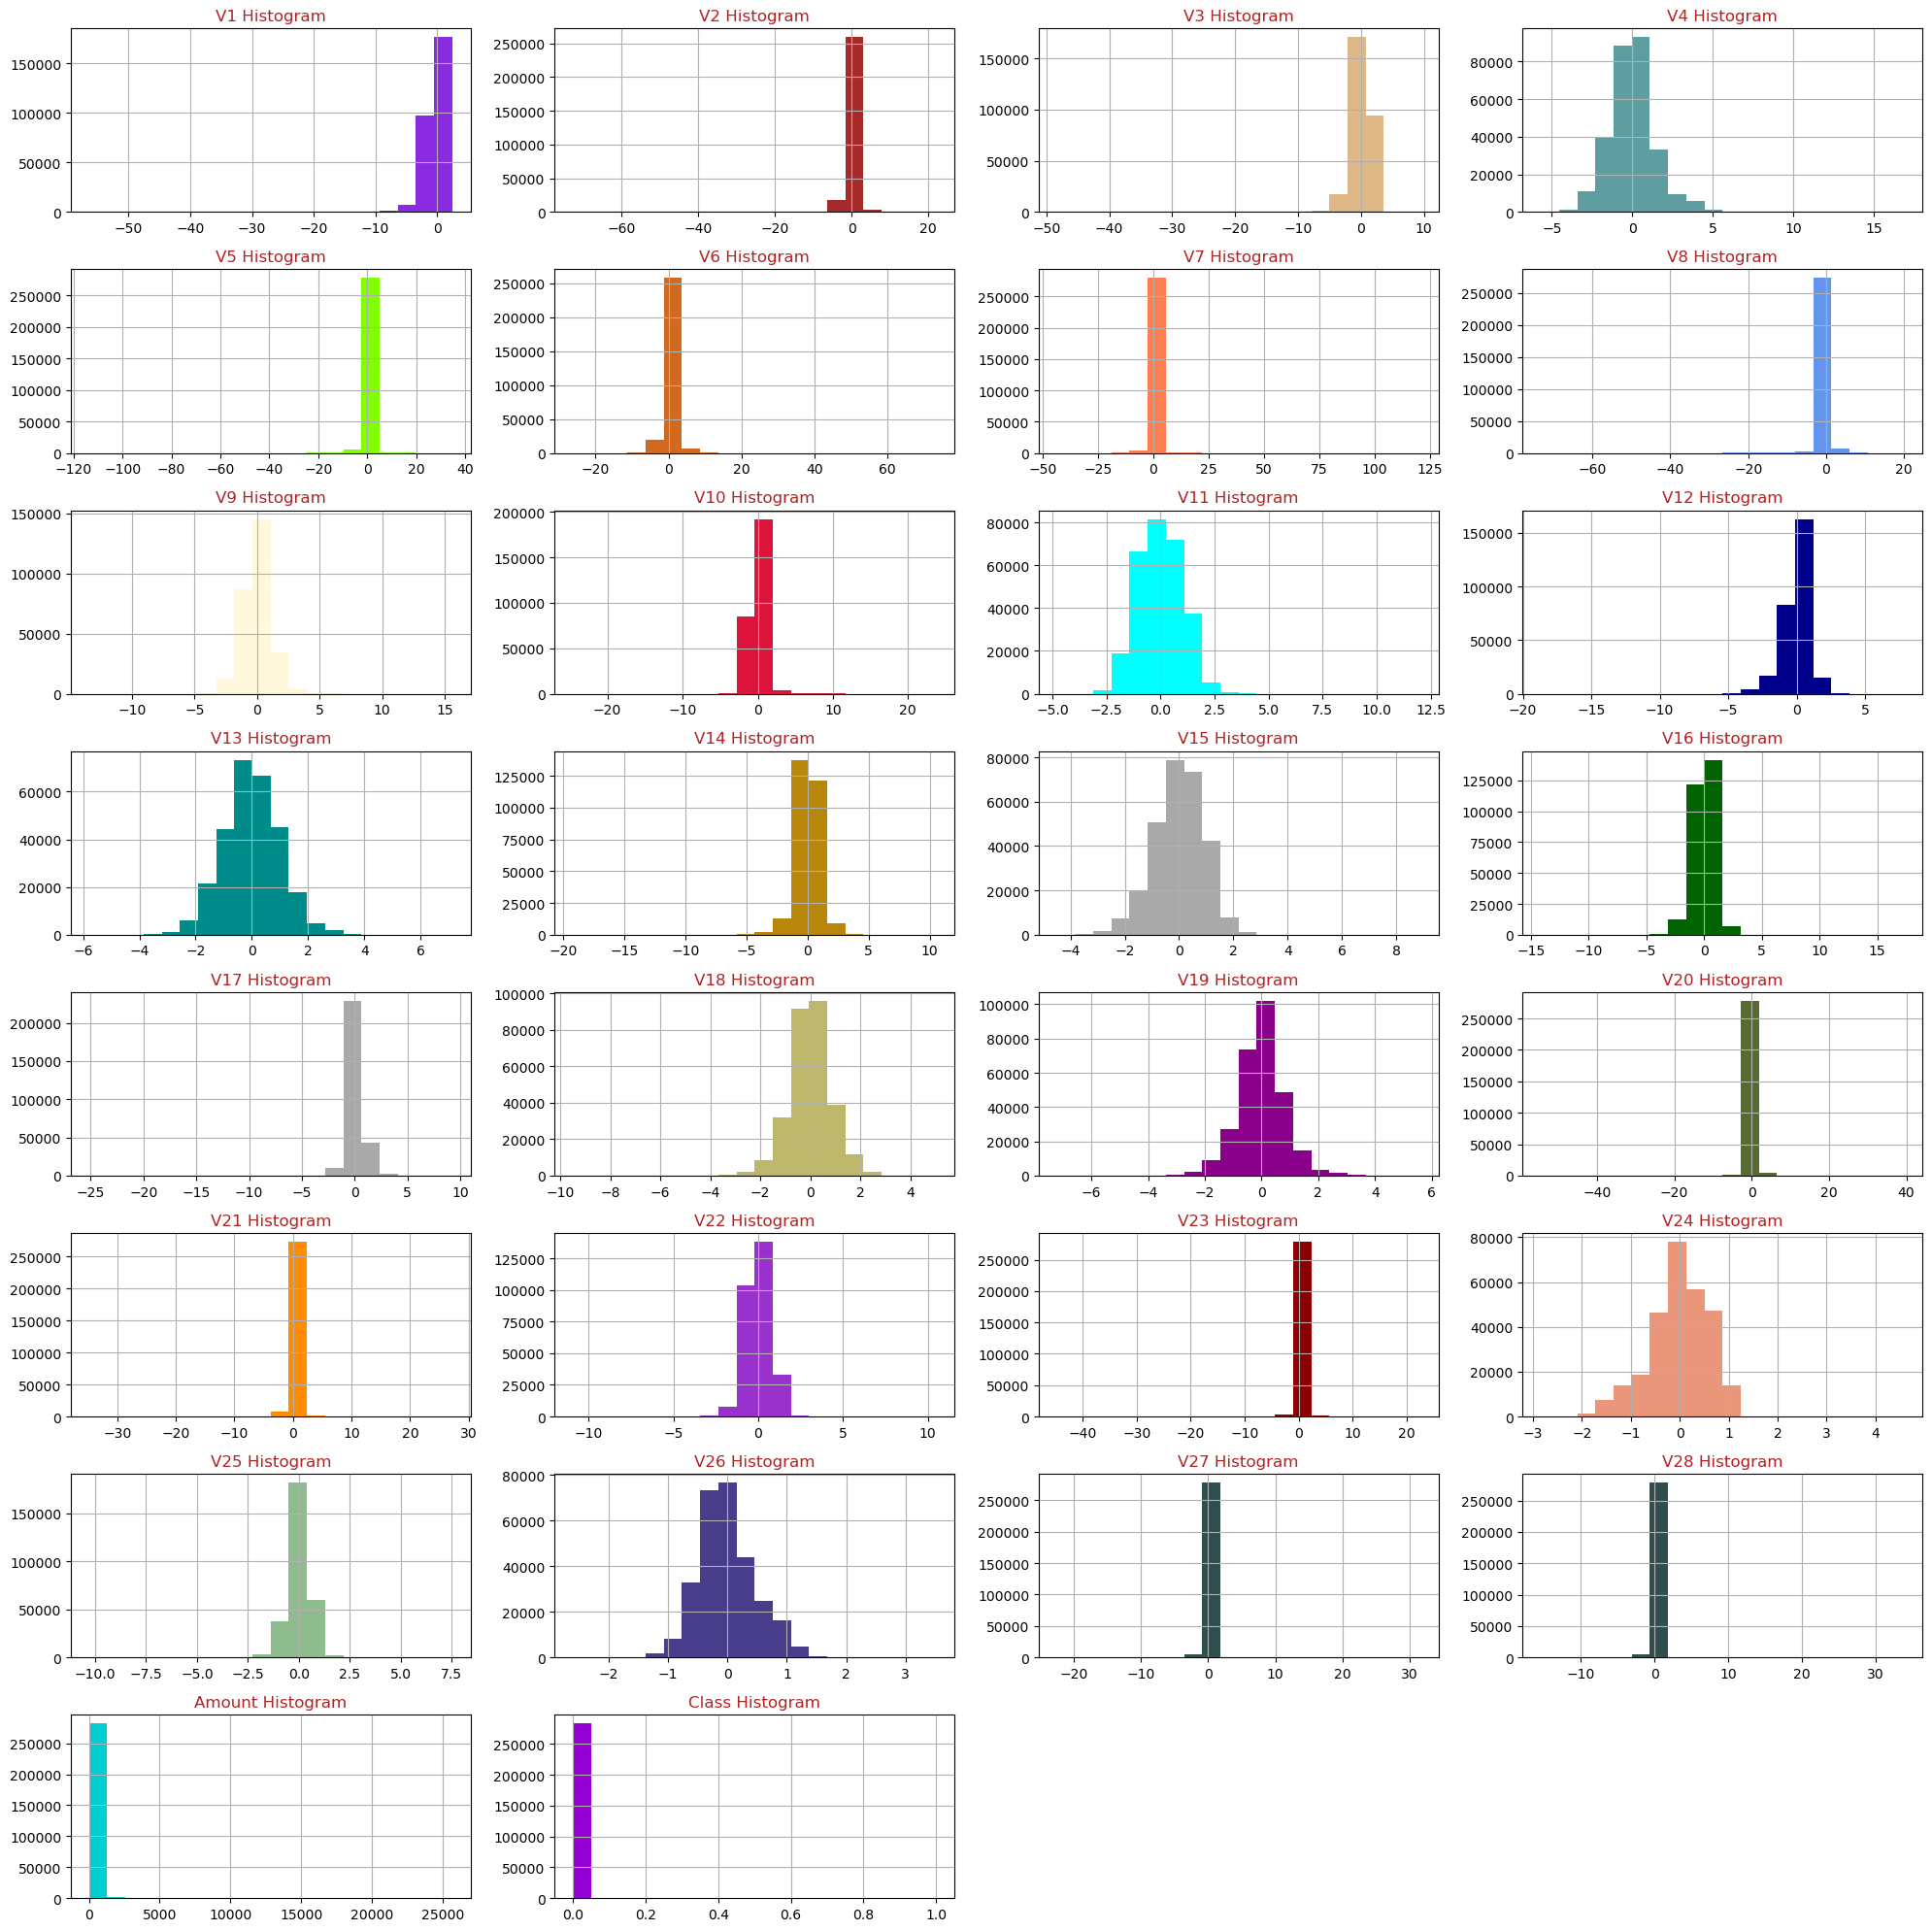

In [17]:
import matplotlib.colors as mcolors
colors = list(mcolors.CSS4_COLORS.keys())[10:]
fig = plt.figure(figsize=(20,20))
for i, feature in enumerate(df.columns):
    f = fig.add_subplot(8, 4, i + 1)
    df[feature].hist(bins = 20, ax = f, facecolor = colors[i])
    f.set_title(feature + " Histogram", color = colors[35])
fig.tight_layout()
plt.show()

Most of these bar-charts look fairly uninteresting.  Also, look at the ticks on the Y-axis.  These values are very large.  When we are plotting values with a very wide range, sometimes logrithmic plots are more informative.  In the following, we added an indication that the Y-axis should use logs:

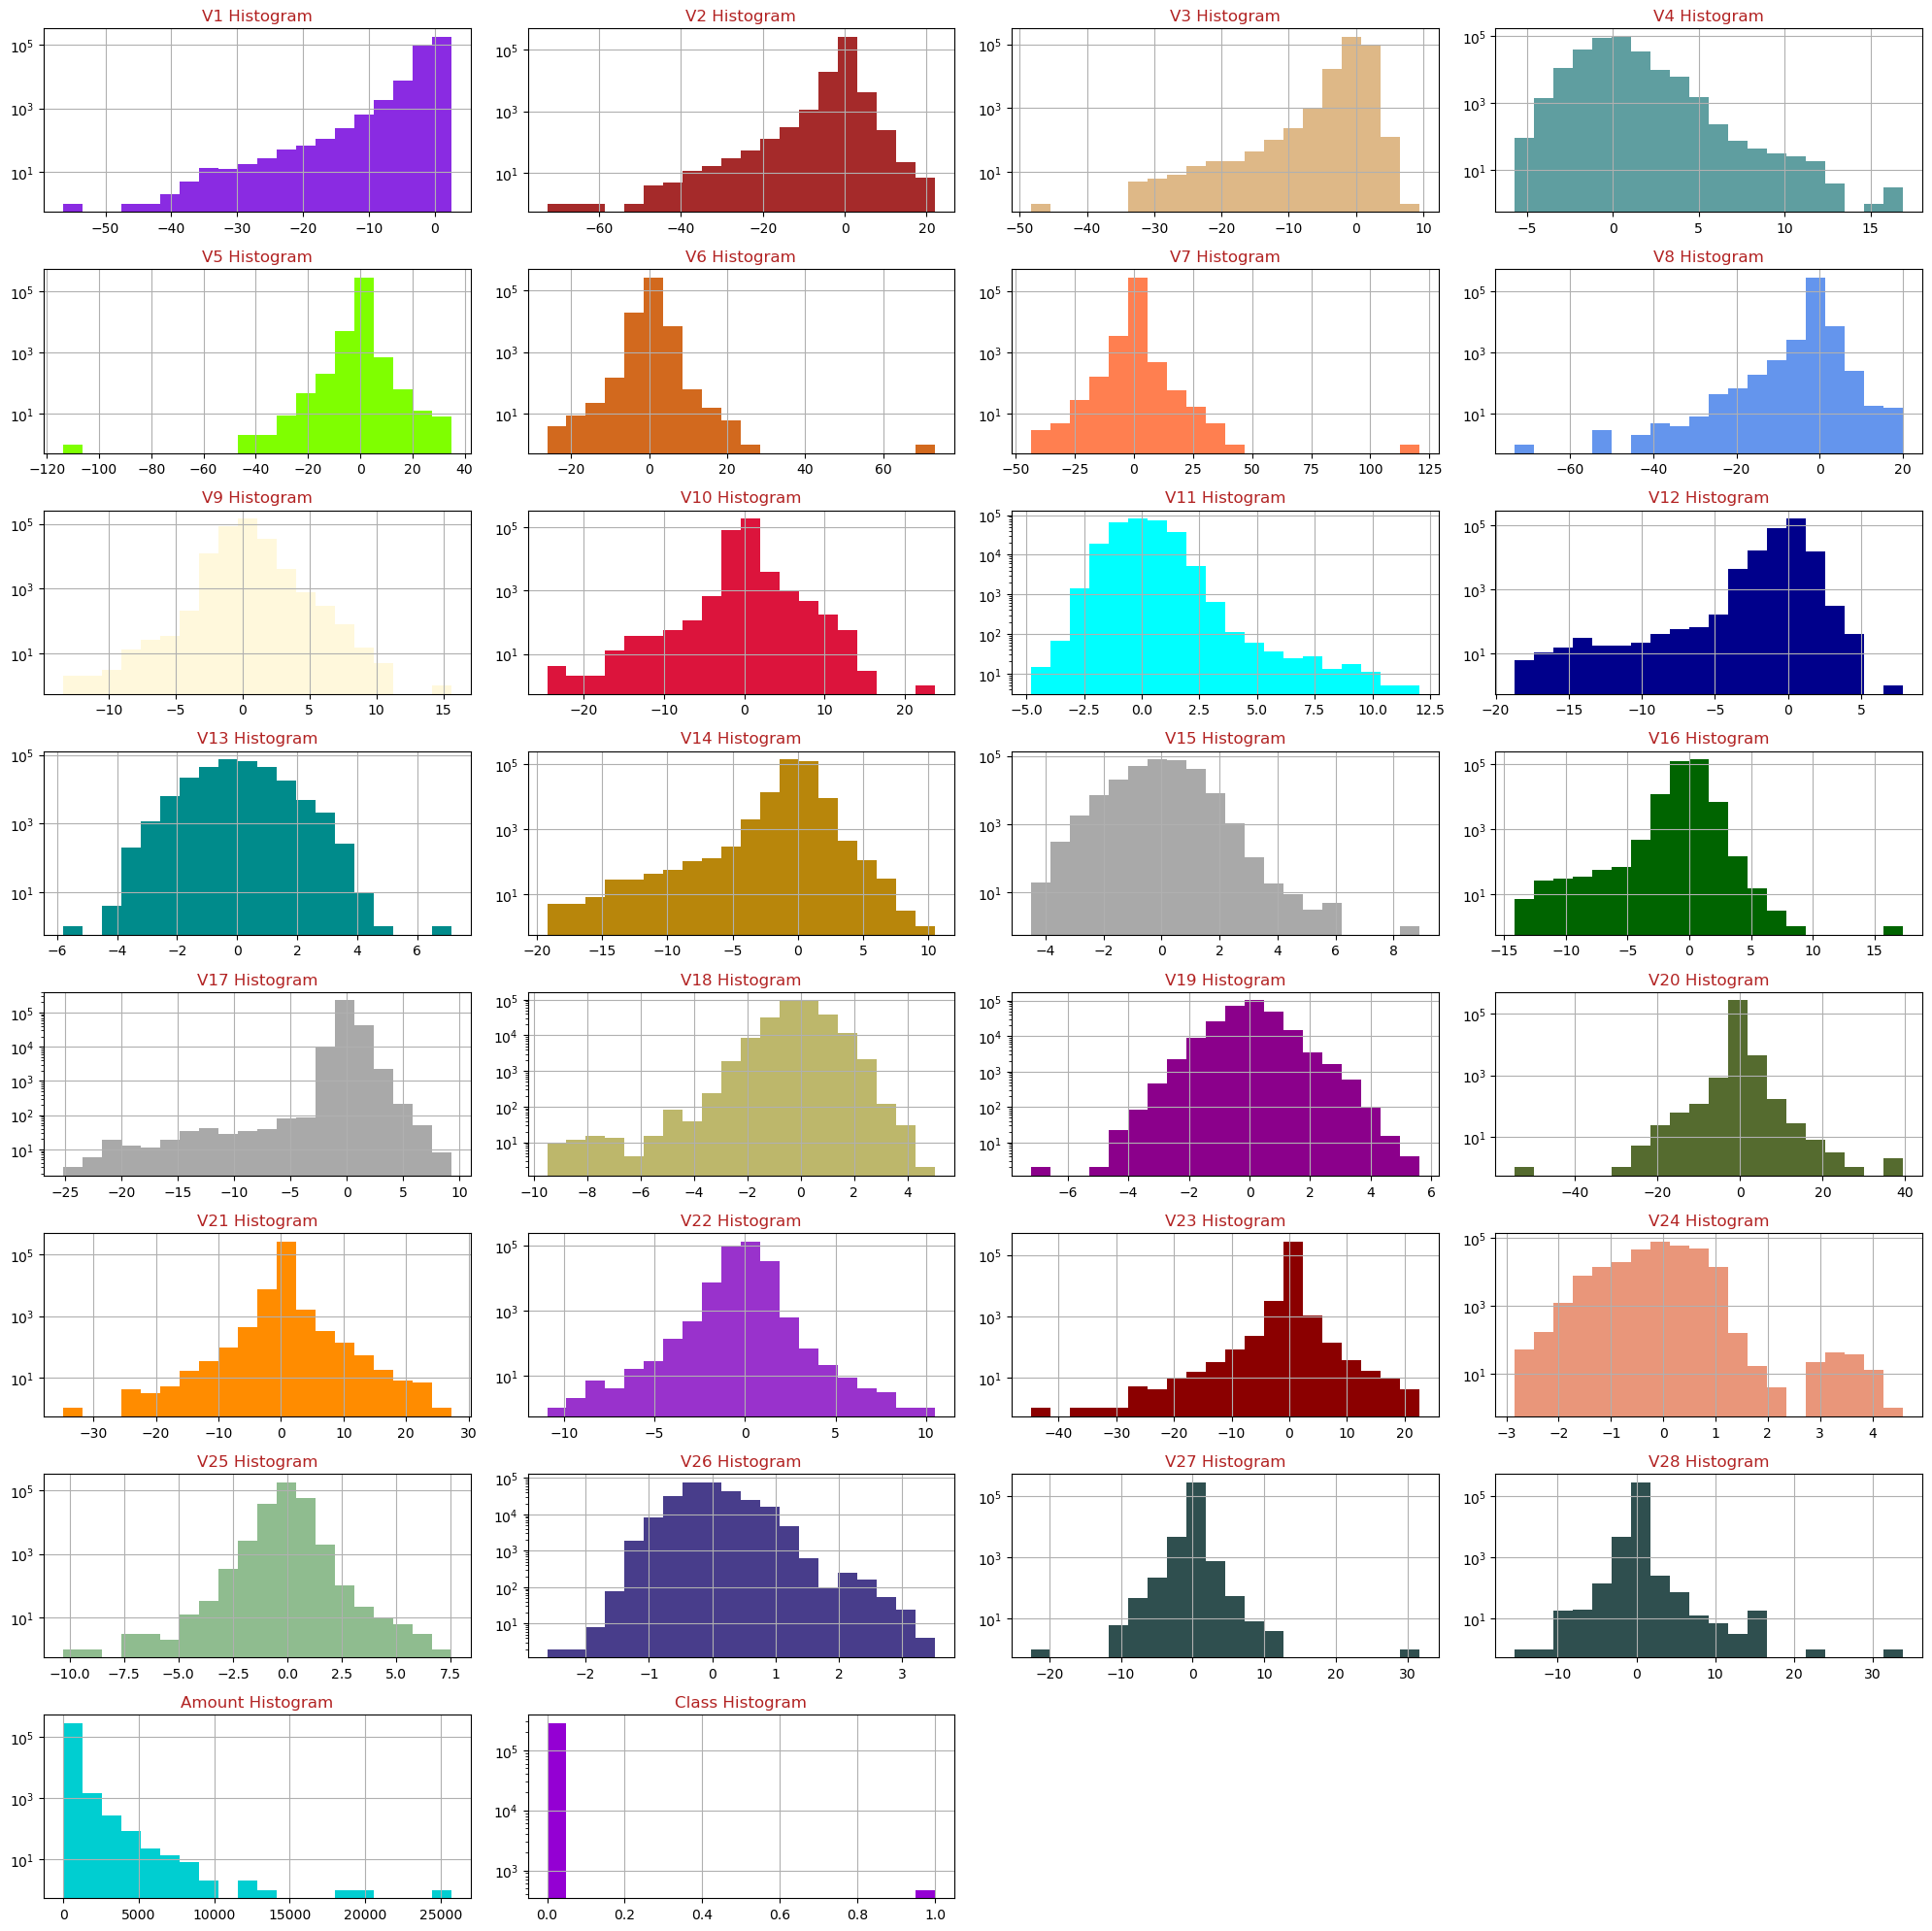

In [18]:
import matplotlib.colors as mcolors
colors = list(mcolors.CSS4_COLORS.keys())[10:]
fig = plt.figure(figsize=(20,20))
for i, feature in enumerate(df.columns):
    f = fig.add_subplot(8, 4, i + 1)
    df[feature].hist(bins = 20, ax = f, facecolor = colors[i])
    f.set_title(feature + " Histogram", color = colors[35])
    f.set_yscale('log')
fig.tight_layout()
plt.show()

That looks a lot better, it brings out information that was hidden in the other graphs.

Another useful thing we did before was generate a Heatmap, to see which variables strongly influence other variables.  If two variables are highly correlated, they can skew the analysis, and also one of the values would not really be required.  This will be a large Heatmap as there are 20 columns.

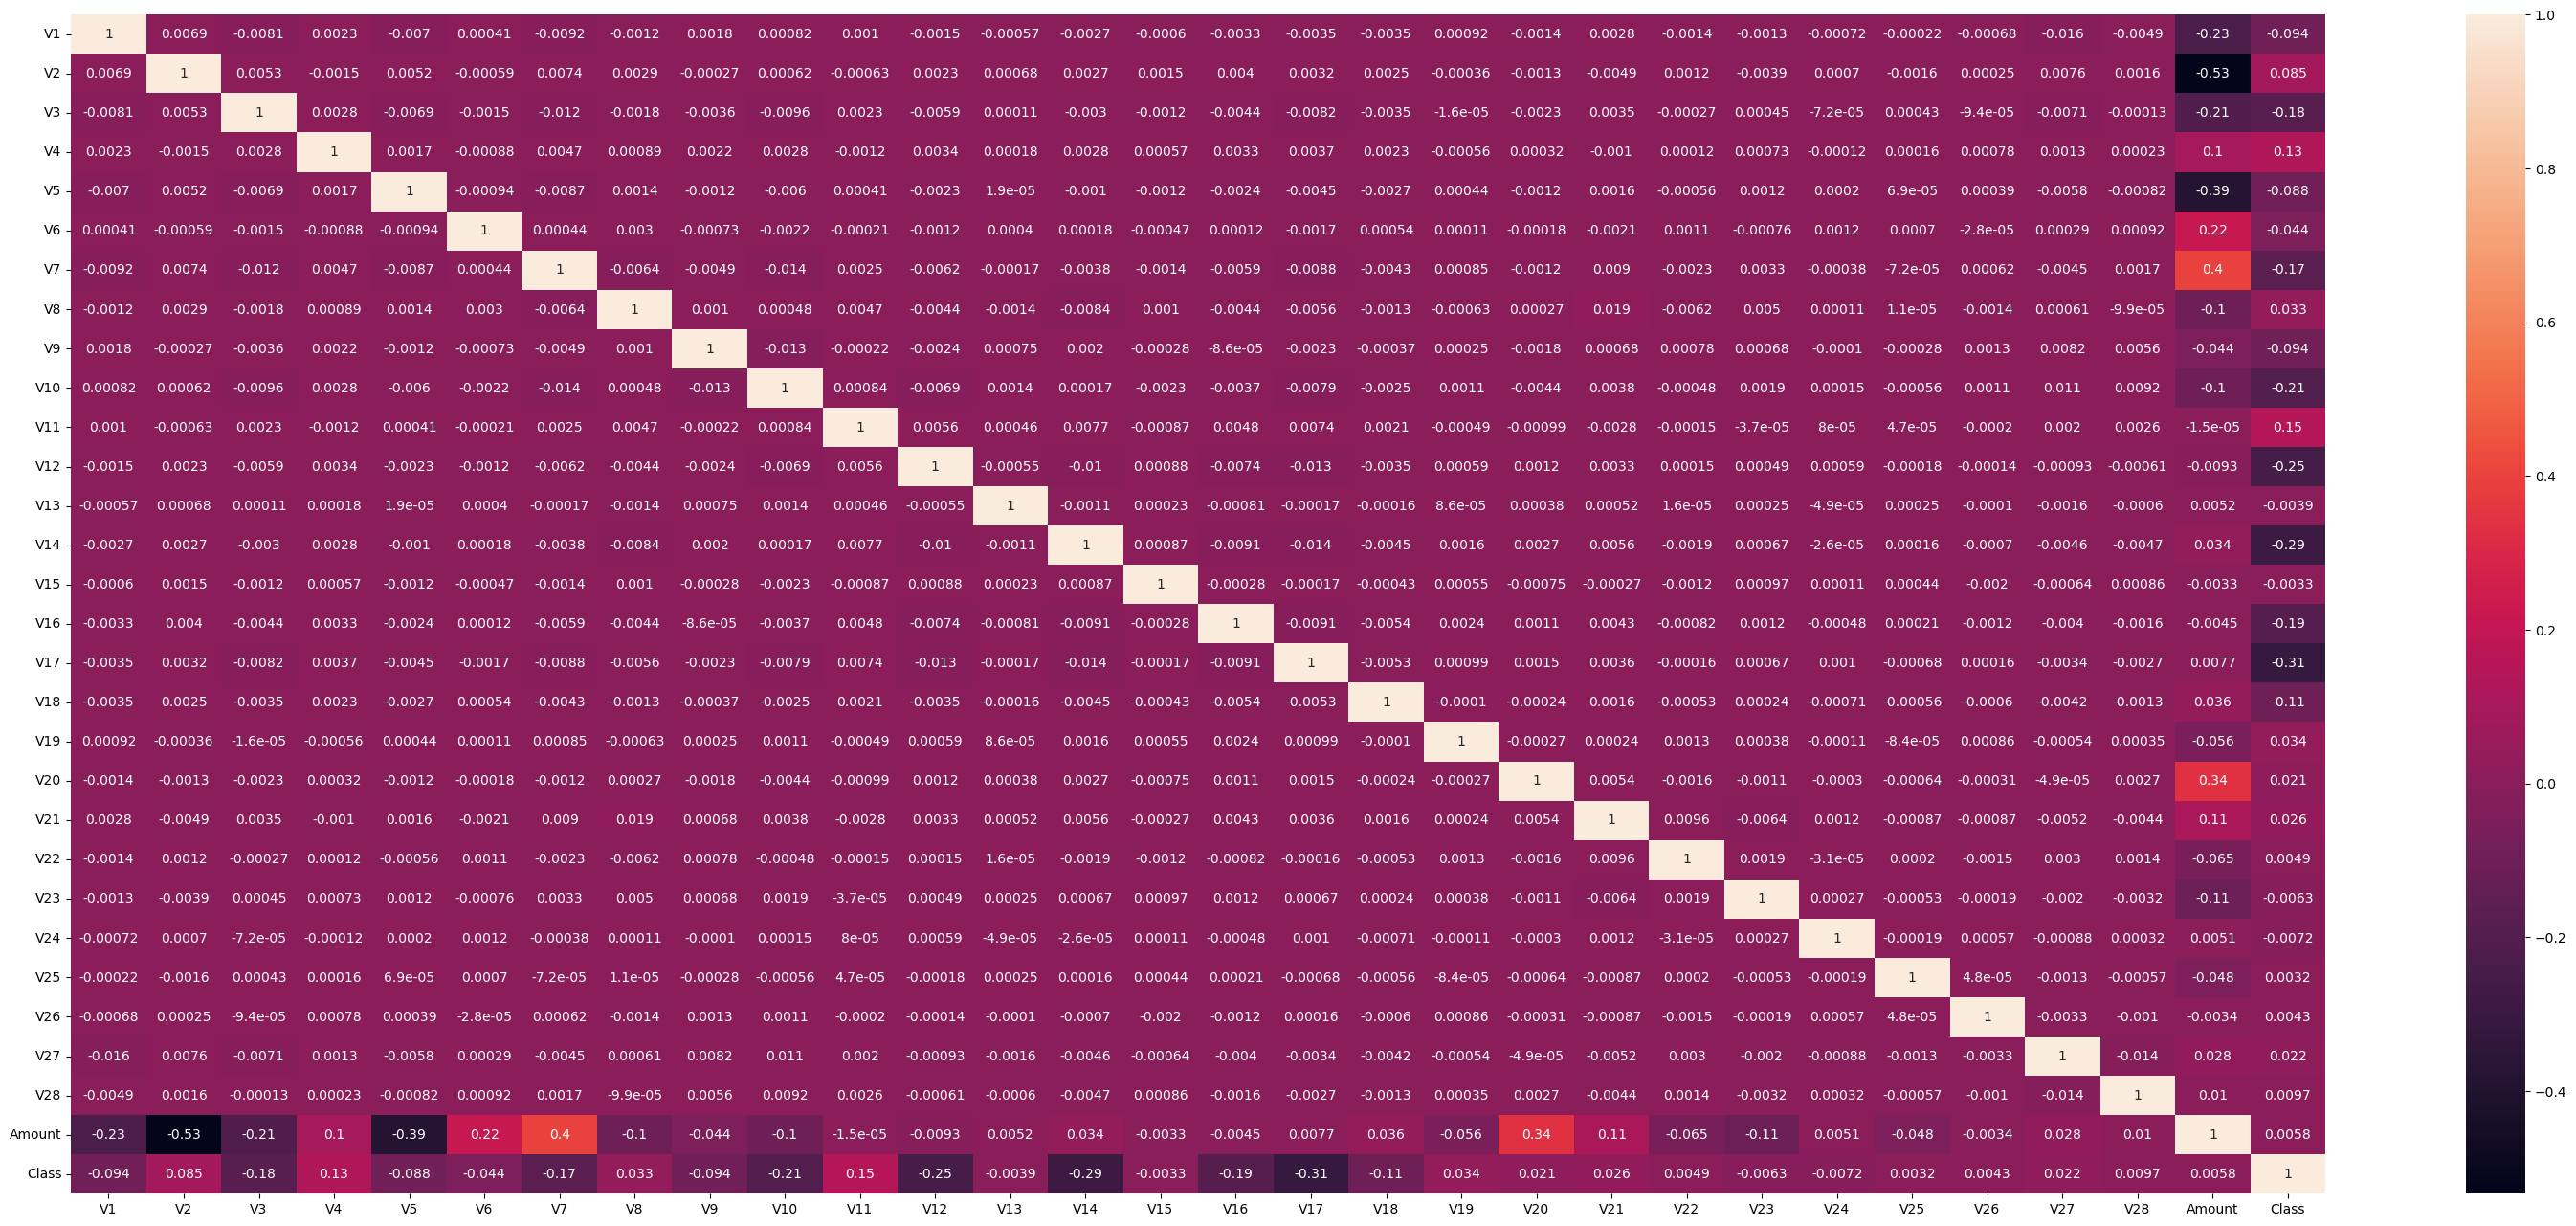

In [19]:
plt.figure(figsize = (38, 16))
sns.heatmap(df.corr(), annot = True)
plt.show()

There is not much correlation between the various columns, except some of the columns have a bit of correlation (positive or negative) with the _Amount_.

## Building the Model and Training

We've done a bit of work to prepare the data, now comes the machine learning part!

In [20]:
model = LogisticRegression();
model.fit(X_train_scaled, y_train)
train_accuracy = model.score(X_train_scaled, y_train)
print(f'The accuracy for the training set is {100 * train_accuracy:.2f}%')
test_accuracy = model.score(X_test_scaled, y_test)
print(f'The accuracy for the test set is {100 * test_accuracy:.2f}%')

The accuracy for the training set is 99.92%
The accuracy for the test set is 99.93%


### Digression

A little digression here.  In the tutorial, that last step was to run the test data, but they didn't run the scaled test data, they ran the unscaled version.  I suspected this might be trouble...  In the following, we run the unscaled, original test data:

In [21]:
test_accuracy = model.score(X_test, y_test)
print(f'The accuracy for the test set is {100 * test_accuracy:.2f}%')

The accuracy for the test set is 57.22%


Yeah, it was trouble.  The problem was that we trained with scaled data, then predicted with unscaled data.

Now let's see why we scaled any of the data in the first place.  Let's train the model on the unscaled data:

In [22]:
model2 = LogisticRegression();
model2.fit(X_train, y_train)
train_accuracy = model2.score(X_train, y_train)
print(f'The accuracy for the training set is {100 * train_accuracy:.2f}%')
test_accuracy = model2.score(X_test, y_test)
print(f'The accuracy for the test set is {100 * test_accuracy:.2f}%')

The accuracy for the training set is 99.92%
The accuracy for the test set is 99.94%


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


So it looks like we really want to scale the data!

## Probabilities and Odds

Recall that the logistics function returns a curve:

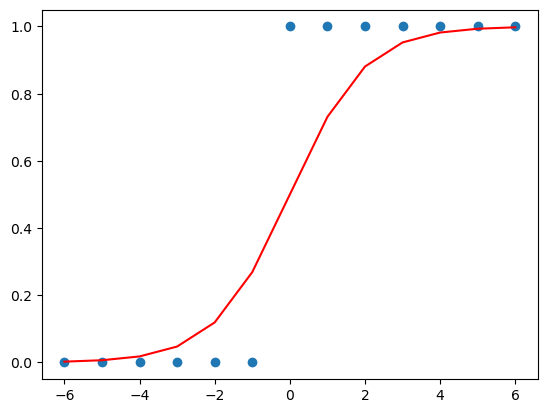

In [23]:
y_values = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
plt.scatter(x_values, y_values)
plt.plot(x_values, log_values, 'r-')
plt.show()

We are trying to use the logistic regression as a _classifier_, we want the code to tell us whether a sample is in _set 1_ or _set 2_.  But the regressor doesn't give us a binary value, _yes_ or _no_.  It gives us a numerical value ranging from 0 to 1.  The regressor is giving us the _probability_ (in some form) that the sample belongs to _set 2_.  For many samples, the regressor's output will be very close to 1.0, so the probability is very high that those samples are in _set 2_, and for other samples, the output will be very close to 0.0, so the probability of being in _set 2_ is very low.  For some samples, the output may be very close to 0.5, meaning that there is a 50% probability the sample is in _set 2_.

Let's talk for a few moments about probabilities and odds.

We will use the term _success_ to mean:

* The event happened
* The sample belongs to _set 2_

We will use the term _failure_ to mean:

* The event did not happen
* The sample does not belong to _set 2_, it belongs to _set 1_.

We will use the term _trial_ to mean:

* One 'sample' where either the event happened or it didn't happen
* One 'sample', which might belong to either _set 1_ or _set 2_.
* The sum of _success_ and _failure_.

The _probability_ of an event is $ \frac{success}{trial} $.  If we flipped a coin 10 times, we would expect to see 5 heads, for a probability of $ \frac{5}{10} $, or 50%.  If there are 3 white balls and 2 black balls in a bag, and we select one at random, the probability of selecting a black ball is $ \frac{2}{5} $, or 40%.

The _odds_ of an event is $ \frac{success}{failure} $.  For our coin toss, the odds of getting heads is 1:1.  The odds of selecting a black ball is 2:3.

Consequently:

* The _probability_ is the ratio of something happening to everything that could happen.
* The _odds_ is the ratio of something happening to something not happening.

Actually, the output of the logistics regression is not _probability_, and it is also not _odds_, it is _log-odds_, it is the log of the odds.

Sklearn's logistics regressor has a method that converts log-odds to probability, so we can see the probability that a sample belongs to _set 1_ and the probability that it belongs to _set 2_.  Naturally, the sum of these two probabilities will be 1 (for a binary logistic regression).

In [24]:
prob = model.predict_proba(X_test_scaled[:3])
prob

array([[9.99882981e-01, 1.17018786e-04],
       [9.99379592e-01, 6.20407802e-04],
       [9.99901995e-01, 9.80048546e-05]])

Here we are looking at the first three values from the test set, asking for their probabilities.

The first sample has a 99.988% probability of being in _set 1_ (not fraud), and a probability of 0.011% to be in _set 2_ (fraud).  The other two samples have similar probabilities.

Actually, those numbers are a little hard to see.  In the following cell, we change the formatting options for numpy:

In [25]:
np.set_printoptions(precision=4, suppress=True)
prob

array([[0.9999, 0.0001],
       [0.9994, 0.0006],
       [0.9999, 0.0001]])

## Multinomial Logistics Regression

We see with binomial logistics regression that the regressor's output gives the probability that the sample belongs in _set 1_ and a probability that it belongs in _set 2_, and that the sum of these two values is 1.0.

For some problems, there are more than two classes.  For example:

* What color of car will be chosen?

* What grade will a student earn in a class?

* What malady is a patient suffering from?

In situations like these, a logistic regressor will actually build a number of sub-regressors, typically using one of the following two strategies:

* One-Versus-Rest (OVR): The system builds _n_ regressors, one for each class.  The probability that regressor _i_ computes is the probability a sample is in class _i_ versus the probability that the sample is in any other class but _i_.

* One-Versus-One (OVO): The system builds $ \frac{n * (n - 1)}{2} $ regressors, one for each pair of classes _i_ and _j_.

By default, the sklearn logistic regressor uses OVR.

## From Boston To California

This second example looks at the housing data.  However, instead of using the Boston data, we'll use some California housing data (this set will not be deprecated soon!)

Sklearn.datasets has a method for fetching this data.  I suspect this might be fetching the data from the web.  The dataset does not have as many features (columns), but it has more rows!

In [1]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [2]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

As before, we will put this into a DataFrame, so it will be more efficient and so we can use some of the DataFrame methods.

In [3]:
housing_df = pd.DataFrame(housing.data, columns = housing.feature_names)
housing_df

NameError: name 'pd' is not defined

We are going to run some multinomial regressions on this, but to do this, we will need our target to have _categories_ rather than a continuous value, which is currently the price.  We can generate a bar graph of the prices to get an idea of the range and distribution of the values:

In [ ]:
temp = pd.Series(housing.target)
temp.hist(histtype = 'stepfilled', bins = 10)

So we see the prices range from 0 to 5, but from the description we know these values are in thousands of dollars.

Let's divide the houses into three categories: those costing 1.5 or less, those costing between 1.5 and 3, and those costing more than 3.

We could make a Series that matches our data, with string entries saying 'Low', 'Medium', and 'High'.  But for expedience, we can make an array called _categ_ which will have a 0 for low priced houses, 1 for medium priced houses, and 2 for high priced houses.

In the following, I built an array called _med_ which will contain a '1' if the house price is greater than 1.5, and '0' otherwise.  Similarly, the array _high_ will contain a '1' for houses priced greater than 3 (and zero otherwise).  The column _categ_ is simply the sum of those two columns, so _categ_ will have:

* 0 if the house price is 1.5 or less
* 1 if the house price is between 1.5 and 3
* 2 if the house price is greater than 3

In [ ]:
med = np.array(housing.target > 1.5).astype(int)
high = np.array(housing.target > 3 ).astype(int)
categ = med + high

The data, both input and output, is now split into the training and test sets.  2/3 of the samples will be in the training set and 1/3 will be in the test set.  However, this time we will scale the data _before_ we split the data

In [ ]:
X_cal = pd.DataFrame(scale(housing_df), columns = housing_df.columns)
X_cal_train, X_cal_test, y_cal_train, y_cal_test = train_test_split(X_cal, categ, test_size=0.33, random_state=5)

We now do the Logistic Regression on the data

In [ ]:
cal_model = LogisticRegression()
cal_model.fit(X_cal_train, y_cal_train)

Since we are doing a Logistics Regression, the model will examine the target to see how many classes are required.  Since the target has the values 0, 1, and 2, there will be three classes.  We can ask the model to print the set of classes:

In [ ]:
print(cal_model.classes_)

The model can now be used for predictions.  Actually, since this is a multinomial regression, it would be interesting to see not just the answer, but to see a comparison of the probabilities for each category.  For each sample in the set, the model will give the probability that this sample belongs to the first category, the probability it belongs in the second, and the probability it belongs in the third category.  These results are stored in the output array.  We will print the first 10 rows of this array.

In [ ]:
probs = cal_model.predict_proba(X_cal_test)
probs[:10]

## Conclusion

In the previous Topic we talked about Linear Regression, and in this Topic we covered Logistic Regression.  These are two powerful tools for data analytics, and both are examples Supervised Learning.  In our next Topic we explore some Unsupervised Learning.